## Building an optimized CNN Model for Morgan fingerprints

This Notebook will uses Keras Tuner to find the best hyperparameters for a CNN model which will label molecules according to their Morgan fingerprints

#### In case the requirements.txt file won't work

In [1]:
#pip install keras_tuner

### Imports

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy import unique
from numpy import argmax
from keras_tuner import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

### Loading data

In [3]:
drugs = pd.read_pickle('../drug-predictor/data/05_model_input/input_table.pickle/2023-09-27T15.46.23.031Z/input_table.pickle')

In [4]:
drugs.head()

,CID,MATC_Code_Short,MATC_Code_Explanation,Molecule,Morgan2FP,MACCSKeys,AtomPairFP,TopTorFP,AvalonFP,PubchemFP,Label
0,24769,B,BLOOD AND BLOOD FORMING ORGANS,<rdkit.Chem.rdchem.Mol object at 0x0000019530B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...",1
1,134694070,C,CARDIOVASCULAR SYSTEM,<rdkit.Chem.rdchem.Mol object at 0x0000019530B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...",2
2,5121,J,ANTIINFECTIVES FOR SYSTEMIC USE,<rdkit.Chem.rdchem.Mol object at 0x0000019530B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",7
3,4660557,N,NERVOUS SYSTEM,<rdkit.Chem.rdchem.Mol object at 0x0000019530B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...",10
4,122175,L,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS,<rdkit.Chem.rdchem.Mol object at 0x00000195253...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",8


### Prepare the data

In [5]:
drugs.columns

Index(['CID', 'MATC_Code_Short', 'MATC_Code_Explanation', 'Molecule',
       'Morgan2FP', 'MACCSKeys', 'AtomPairFP', 'TopTorFP', 'AvalonFP',
       'PubchemFP', 'Label'],
      dtype='object')

We have found that Morgan fingerprints are the ones returning the best accuracy in a CNN model (look select_fingerprints.ipynb)

In [6]:
#Choose fingerprints to train with
X = drugs['Morgan2FP']
y = drugs['Label']

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Reshaping the arrays to fit in the model
x_train = np.array(list(X_train))
x_test = np.array(list(X_test))
print('Shape x_train: ', x_train.shape)
n_classes = len(unique(y_train))
print('Number of classes: ', n_classes)
x_train= x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test= x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print('Reshaped x_train: ', x_train.shape)
in_shape = x_train.shape[1:]
print('In_shape: ', in_shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Shape x_train:  (135, 2048)
Number of classes:  15
Reshaped x_train:  (135, 2048, 1)
In_shape:  (2048, 1)
(135, 2048, 1) (135,)
(58, 2048, 1) (58,)


### Tuning the model

Building the model

In [9]:
#model with tuner choosing number of layers

def build_model_kt(hp):
    """
    Function that chooses the best hyperparameters for a CNN model and then compiles it.
    Input: a set of hyperparamneters
    Output: a cnn model
    """
    # Create model object
    model = keras.Sequential()
    # Choose number of layers
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(2048, 1)))
        model.add(layers.MaxPool1D(hp.Int('pool_size', min_value=2, max_value=6)))
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu', kernel_initializer = 'he_uniform'
    ))

    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='softmax'))

    # Compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [10]:
def build_model_hand(inshape, nclasses):
    """
    Function that builds a CNN model with non optimal conditions.
    Input: tuple with inner shape of arrays, integer with number of classes
    Output: a CNN model
    """
    model = Sequential()

    model.add(layers.InputLayer(input_shape=in_shape))
    model.add(Conv1D(32, 9, activation='relu', kernel_initializer='he_uniform', input_shape=inshape))
    model.add(MaxPool1D(2))

    model.add(Dropout(0.3))

    model.add(Conv1D(64, 9, activation='relu', kernel_initializer='he_uniform', input_shape=inshape))
    model.add(MaxPool1D(2))

    model.add(Dropout(0.3))

    model.add(Conv1D(128, 9, activation='relu', kernel_initializer='he_uniform', input_shape=inshape))
    model.add(MaxPool1D(2))

    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(nclasses, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

Tuning the model

In [11]:
tuner = RandomSearch(build_model_kt,
                    objective='val_loss',
                    max_trials = 5,
                    directory = os.path.join('temp', 'tuner', 'RS_tuned_model', '280930_01'))
tuner.search(x_train,y_train,epochs=3,validation_data=(x_test,y_test))

INFO:tensorflow:Reloading Tuner from temp\tuner\RS_tuned_model\280930_01\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


Obtain and save the model

In [12]:
tuned_model_kt = tuner.get_best_models(num_models=1)[0]
tuned_model_kt.summary()
#tuned_model.save(os.path.join('compiled_models','tuned', 'opt_morgan_model'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2044, 112)         672       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 681, 112)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 681, 112)          0         
                                                                 
 flatten (Flatten)           (None, 76272)             0         
                                                                 
 dense (Dense)               (None, 128)               9762944   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [13]:
tuned_model_hand = build_model_hand(in_shape, n_classes)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2040, 32)          320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1020, 32)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1020, 32)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1012, 64)          18496     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 506, 64)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 506, 64)          

In [14]:
loss, acc = tuned_model_kt.evaluate(x_test, y_test, verbose=1)

2/2 [==============================] - 0s 16ms/step - loss: 1.2883 - accuracy: 0.6207


In [15]:
loss, acc

(1.2882808446884155, 0.6206896305084229)

In [16]:
# Configure early stopping
es = EarlyStopping(monitor='val_loss', patience=1)
mc = ModelCheckpoint(filepath = os.path.join('compiled_models','checkpoints', '{epoch:02d}-{val_accuracy:.3f}.hdf5'), monitor = 'val_loss', save_best_only = True)

# Fit the model
tuned_model_kt.fit(x_train, y_train, epochs=200, batch_size=128, verbose=1, validation_split = 0.3, callbacks = [es,mc])
history_dic = tuned_model_kt.history.history

# Evaluate the model
loss, acc = tuned_model_kt.evaluate(x_test, y_test, verbose=1)

Epoch 1/200


1/1 [==============================] - 1s 739ms/step - loss: 1.4323 - accuracy: 0.6702 - val_loss: 1.6145 - val_accuracy: 0.6098
Epoch 2/200
1/1 [==============================] - 0s 354ms/step - loss: 1.4135 - accuracy: 0.6064 - val_loss: 1.6007 - val_accuracy: 0.6098
Epoch 3/200
1/1 [==============================] - 0s 333ms/step - loss: 1.3174 - accuracy: 0.6489 - val_loss: 1.5867 - val_accuracy: 0.6098
Epoch 4/200
1/1 [==============================] - 0s 343ms/step - loss: 1.3794 - accuracy: 0.5851 - val_loss: 1.5700 - val_accuracy: 0.6098
Epoch 5/200
1/1 [==============================] - 0s 346ms/step - loss: 1.2687 - accuracy: 0.6383 - val_loss: 1.5517 - val_accuracy: 0.6098
Epoch 6/200
1/1 [==============================] - 0s 378ms/step - loss: 1.4211 - accuracy: 0.6383 - val_loss: 1.5318 - val_accuracy: 0.6098
Epoch 7/200
1/1 [==============================] - 0s 353ms/step - loss: 1.0811 - accuracy: 0.6383 - val_loss: 1.5124 - val_accuracy: 0.6098
Epoch 8/200
1/1 [========

In [17]:
history_dic['loss'][1]

1.4134867191314697

In [18]:
loss, acc

(1.3348289728164673, 0.6206896305084229)

In [19]:
loss, acc = tuned_model_kt.evaluate(x_test, y_test, verbose=1)
loss, acc

2/2 [==============================] - 0s 15ms/step - loss: 1.3348 - accuracy: 0.6207


(1.3348289728164673, 0.6206896305084229)

In [20]:
# Getting test predictions
y_pred = tuned_model_hand.predict(x_test)
y_pred_list = [argmax(x) for x in y_pred]

2/2 [==============================] - 0s 21ms/step


In [21]:
# Save predictions
y_pred_ser = pd.Series(y_pred_list)
y_pred_ser.to_pickle(path= os.path.join('predictions', 'y_preds.pkl'))

#### Visualization of models accuracy

In [22]:
let_y_labels = list('abcdefghijklmnop')

In [23]:
num_y_labels = [x for x in range(16)]

In [24]:
dic_lab = dict(zip(num_y_labels,let_y_labels))

In [25]:
classes = unique(y_test)
list(classes)

[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 14]

In [26]:
or_classes = unique(y_pred_list)
or_classes

array([ 0,  2,  5,  6,  7,  9, 10, 11, 13, 14], dtype=int64)

In [27]:
total_classes = list(set(classes).union(set(or_classes)))
total_classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14]

In [28]:
y_labels = [x for x in range(n_classes-1)]
y_labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [29]:
n_classes

15

In [30]:
with open(os.path.join('..', 'drug-predictor', 'data', '03_primary', 'code_to_label_dic.json')) as file:
    code_to_label_dic = json.load(file)

In [31]:
code_to_label_dic

{'0': 'ALIMENTARY TRACT AND METABOLISM',
 '1': 'BLOOD AND BLOOD FORMING ORGANS',
 '2': 'CARDIOVASCULAR SYSTEM',
 '3': 'DERMATOLOGICALS',
 '4': 'GENITO URINARY SYSTEM AND SEX HORMONES',
 '5': 'SYSTEMIC HORMONAL PREPARATIONS EXCL. SEX HORMONES AND INSULINS',
 '6': 'ANTIINFLAMMATORY',
 '7': 'ANTIINFECTIVES FOR SYSTEMIC USE',
 '8': 'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS',
 '9': 'MUSCULO-SKELETAL SYSTEM',
 '10': 'NERVOUS SYSTEM',
 '11': 'ANTIPARASITIC PRODUCTS INSECTICIDES AND REPELLENTS',
 '12': 'RESPIRATORY SYSTEM',
 '13': 'SENSORY ORGANS',
 '14': 'VARIOUS'}

In [32]:
def plot_confusion_matrix(y_pred, y_true):
  #cm=metrics.confusion_matrix(y_true,y_pred,normalize=norm)
  new_y_labels = [code_to_label_dic[str(y)] for y in total_classes]
  print(new_y_labels)
  disp=metrics.ConfusionMatrixDisplay.from_predictions(y_true,y_pred, normalize='true', display_labels=new_y_labels, xticks_rotation='vertical',)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax, xticks_rotation=90)
  return disp.figure_

['ALIMENTARY TRACT AND METABOLISM', 'BLOOD AND BLOOD FORMING ORGANS', 'CARDIOVASCULAR SYSTEM', 'DERMATOLOGICALS', 'GENITO URINARY SYSTEM AND SEX HORMONES', 'SYSTEMIC HORMONAL PREPARATIONS EXCL. SEX HORMONES AND INSULINS', 'ANTIINFLAMMATORY', 'ANTIINFECTIVES FOR SYSTEMIC USE', 'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS', 'MUSCULO-SKELETAL SYSTEM', 'NERVOUS SYSTEM', 'ANTIPARASITIC PRODUCTS INSECTICIDES AND REPELLENTS', 'SENSORY ORGANS', 'VARIOUS']


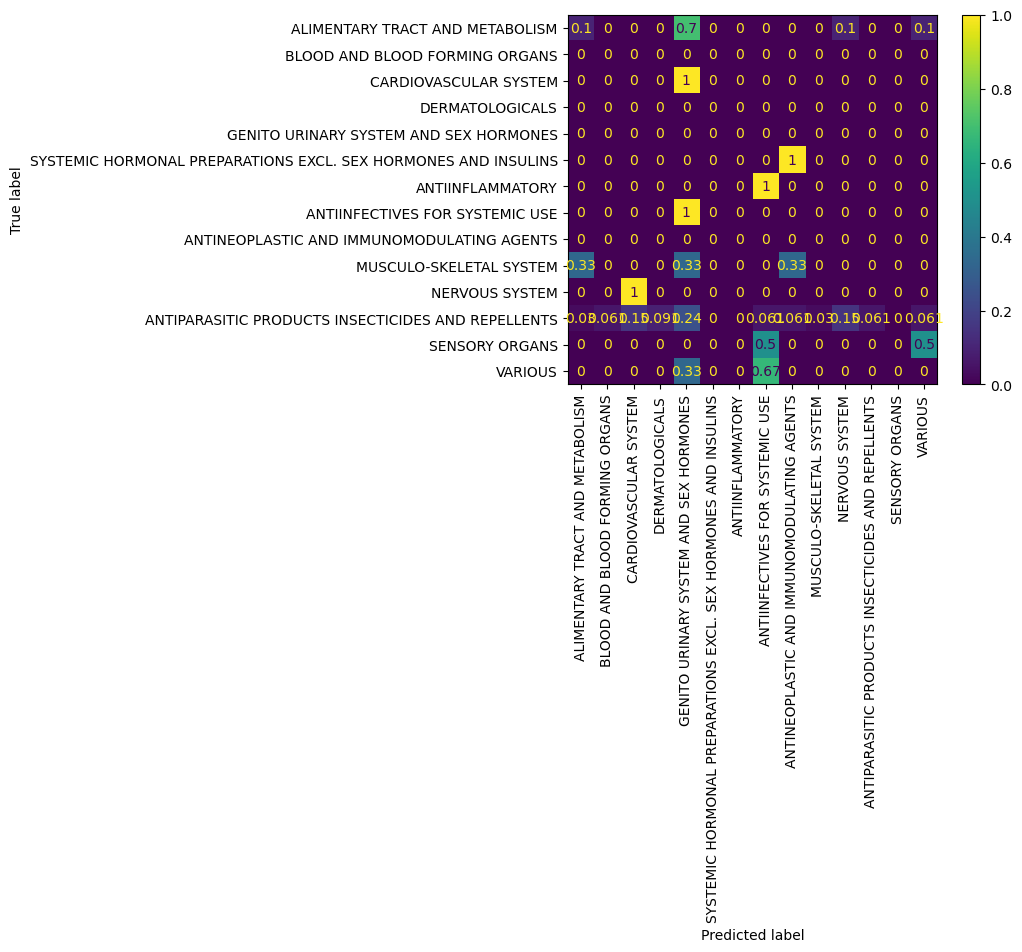

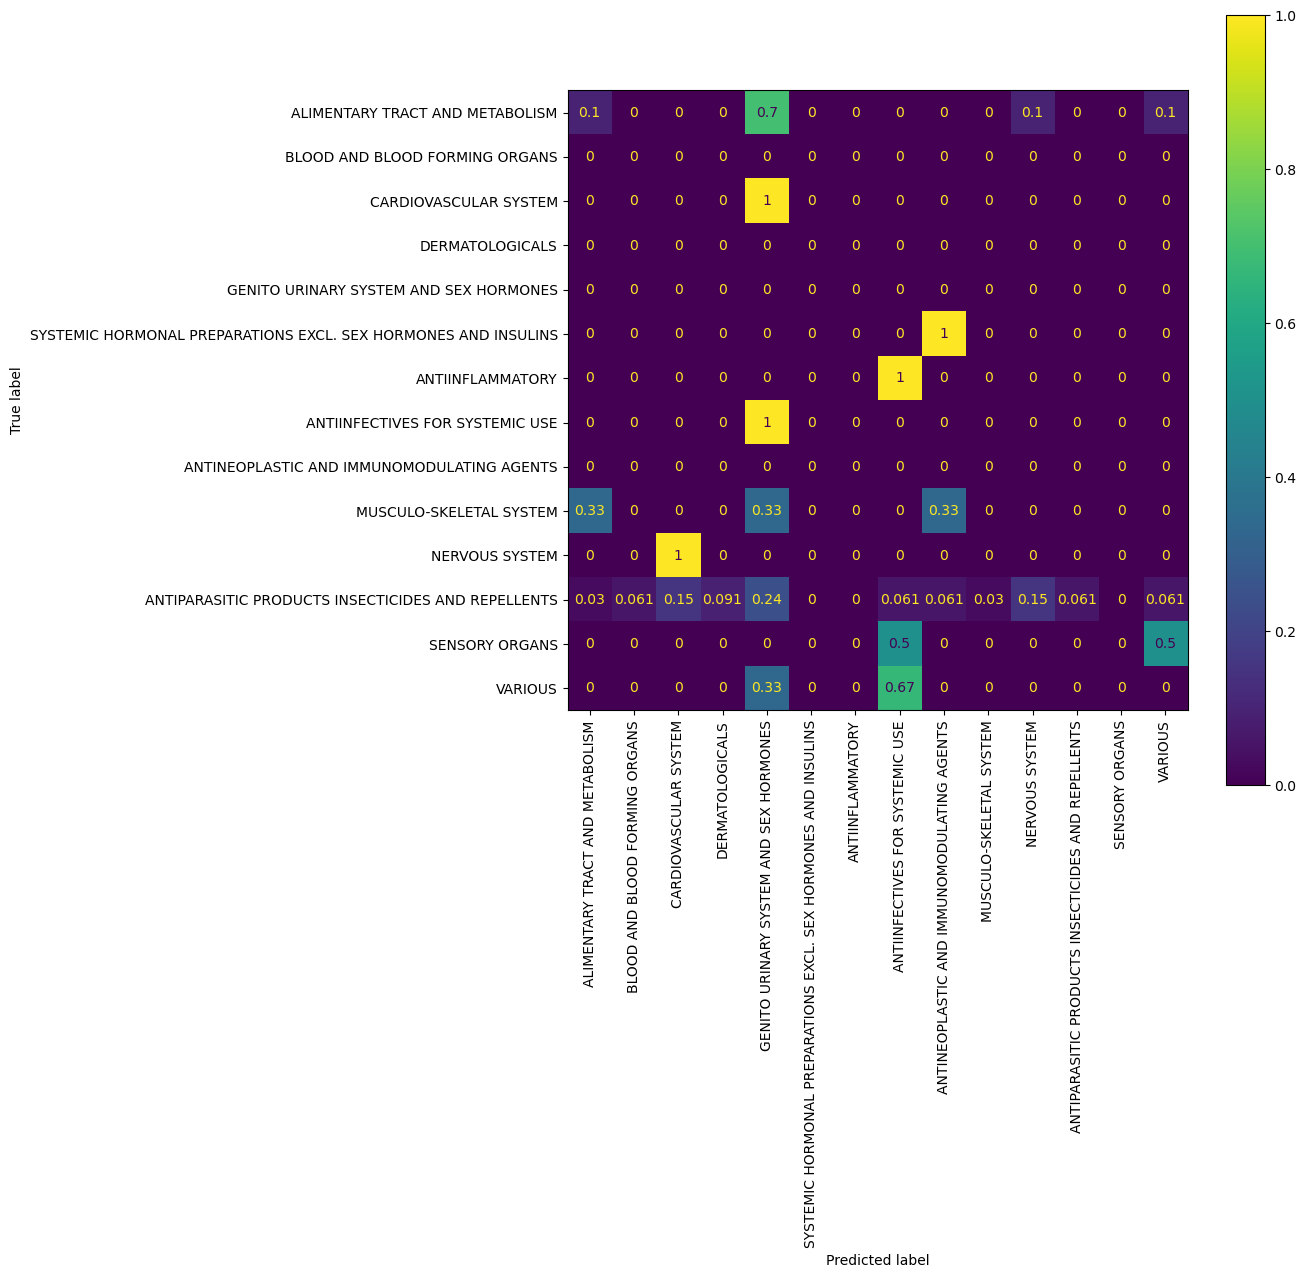

In [33]:
figure = plot_confusion_matrix(y_test,y_pred_list)
figure.savefig('temp/cm.png')

In [34]:
type(figure)

matplotlib.figure.Figure

              precision    recall  f1-score   support

           0       0.10      0.33      0.15         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         6
          11       0.06      1.00      0.11         2
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         4

    accuracy                           0.05        58
   macro avg       0.01      0.10      0.02        58
weighted avg       0.01      0.05      0.01        58

['ALIMENTARY TRACT AND ME

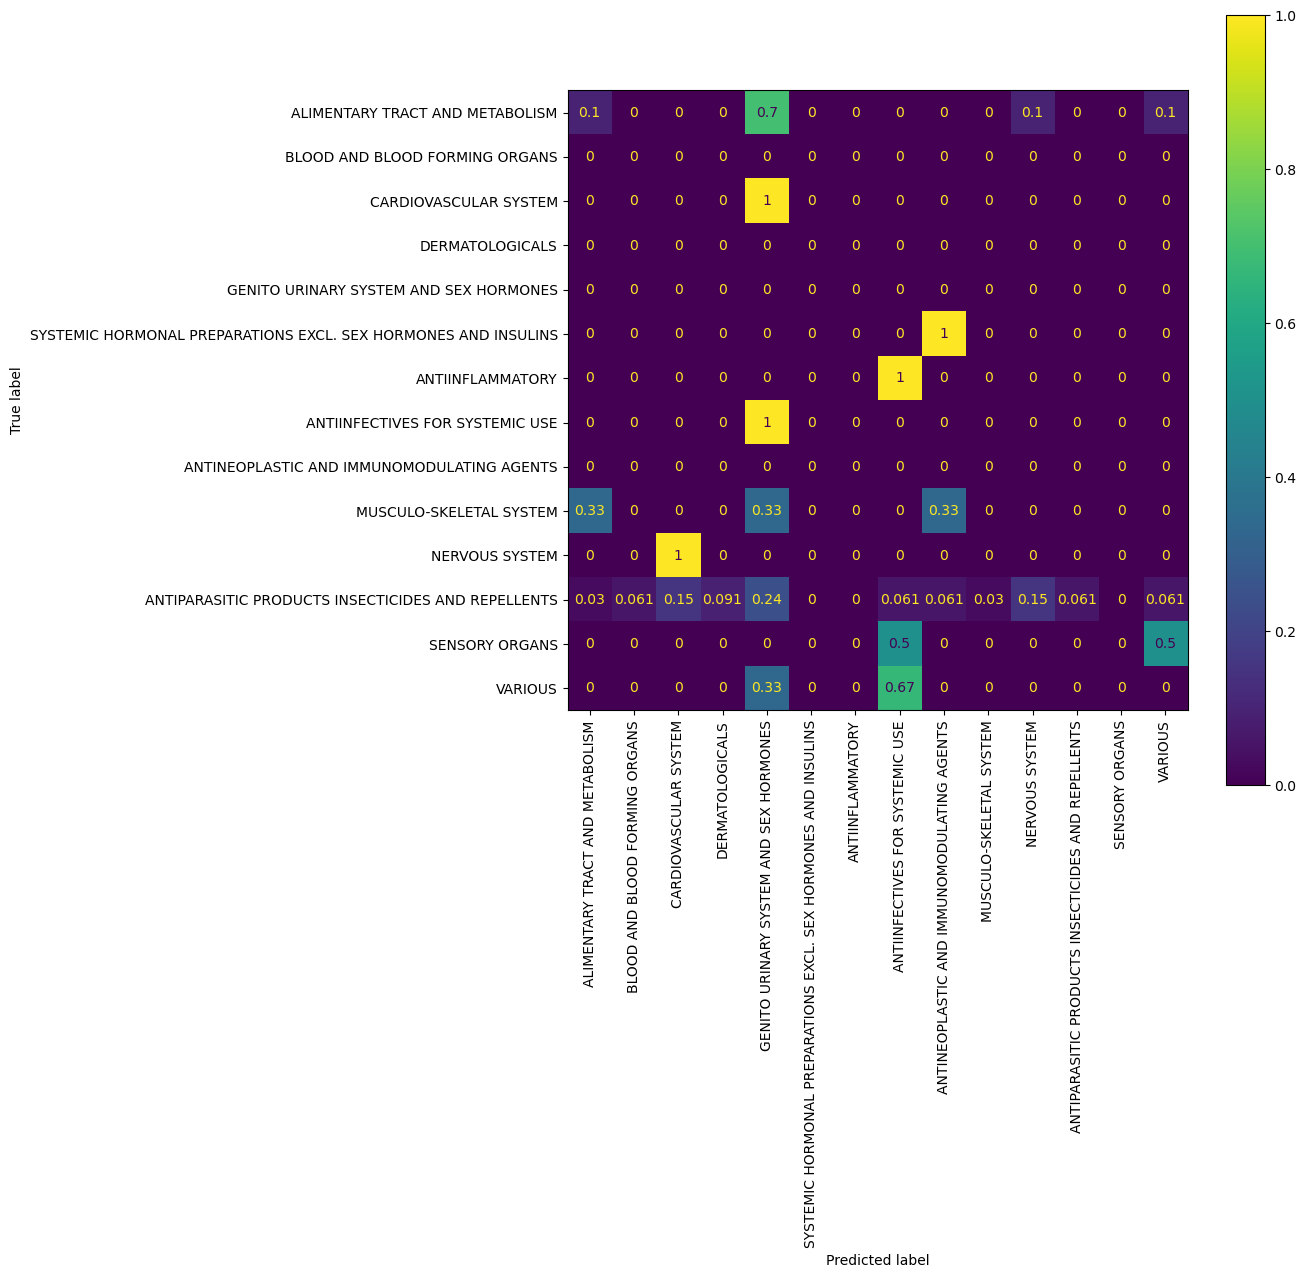

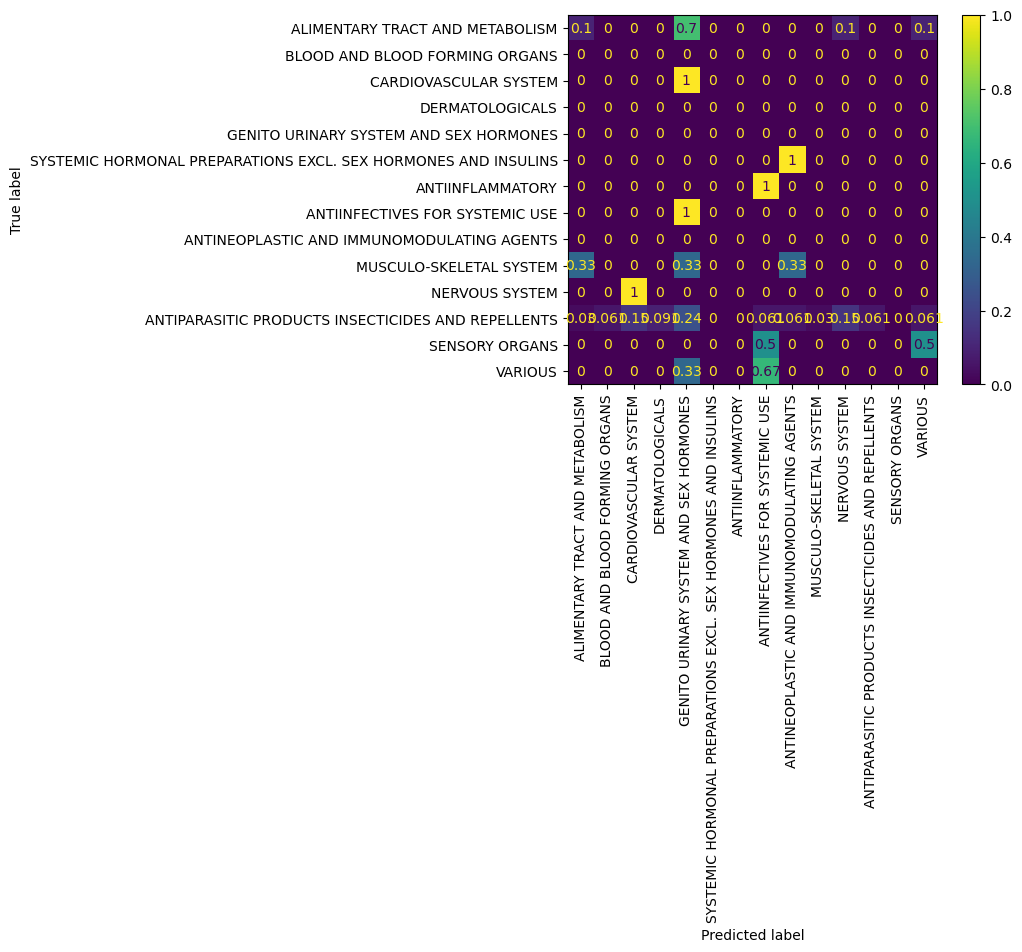

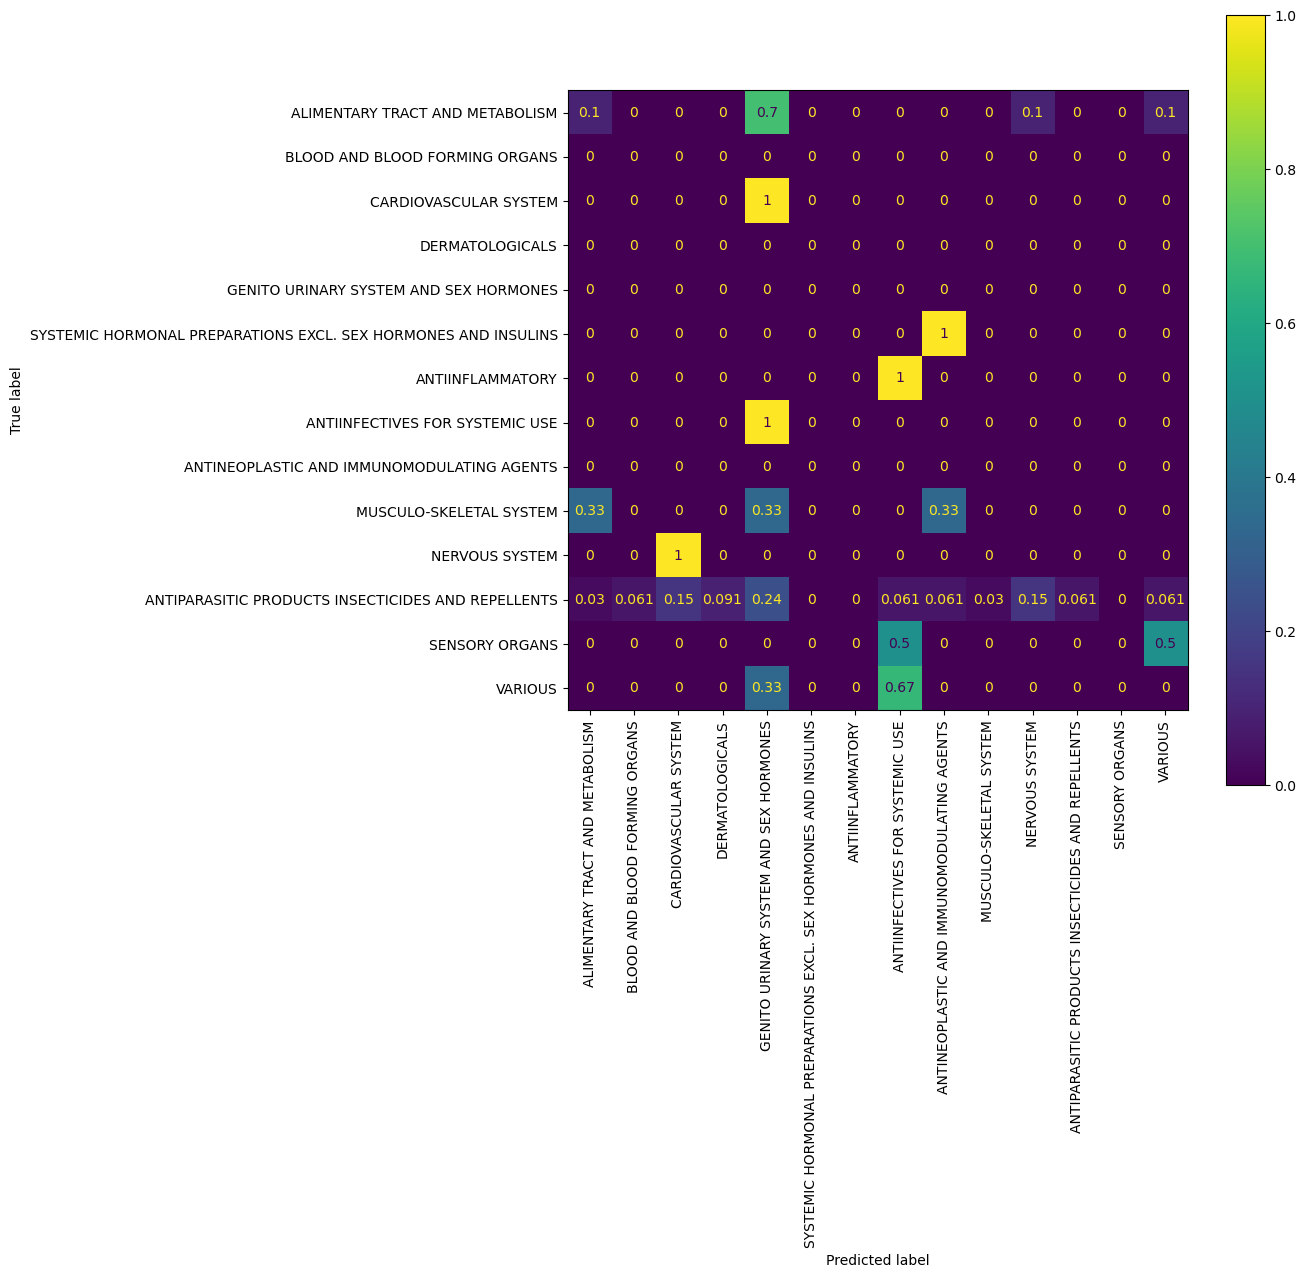

In [35]:
# Precission and recall for every variable
print(metrics.classification_report(y_test,y_pred_list))
plot_confusion_matrix(y_test,y_pred_list)

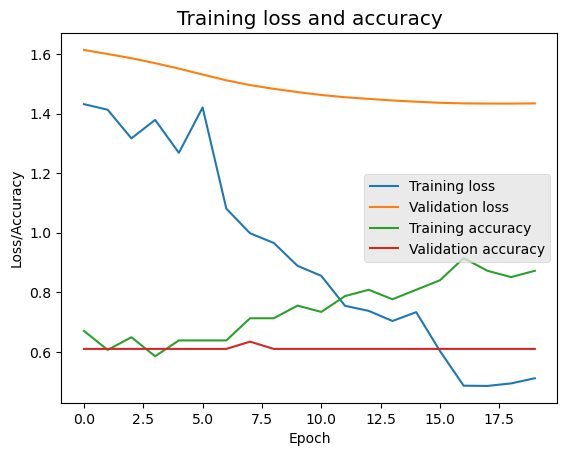

In [36]:
#Learning curve visualization

fig,ax = plt.subplots()
plt.style.use('ggplot')

epochs = len(history_dic['loss'])
epoch_values = list(range(epochs))

ax.plot(epoch_values, history_dic['loss'], label='Training loss')
ax.plot(epoch_values, history_dic['val_loss'], label='Validation loss')
ax.plot(epoch_values, history_dic['accuracy'], label='Training accuracy')
ax.plot(epoch_values, history_dic['val_accuracy'], label='Validation accuracy')

ax.set_title('Training loss and accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.legend()
plt.show()

In [37]:
loaded_model = load_model(os.path.join('compiled_models','checkpoints', '04-0.991.hdf5'))

TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

In [ ]:
y_pred = loaded_model.predict(x_test)
y_pred_list = [argmax(x) for x in y_pred]

66/66 [==============================] - 2s 26ms/step


In [ ]:
print(metrics.classification_report(y_test,y_pred_list))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       721
           1       0.81      0.82      0.82        95
           2       0.78      0.78      0.78       372
           3       0.74      0.73      0.74       232
           4       0.70      0.83      0.76       341
           5       0.68      0.48      0.57        27
           6       0.94      0.68      0.79        75
           7       0.77      0.55      0.64        85
           8       0.93      0.66      0.77        56
           9       0.88      0.90      0.89        39
          10       0.94      0.53      0.68        32
          11       1.00      0.33      0.50         6

    accuracy                           0.80      2081
   macro avg       0.84      0.68      0.73      2081
weighted avg       0.81      0.80      0.80      2081

